In [1]:
from multisensory_playbook import (
    ClassicalTask,
    DetectionTask,
    DetectionTask_versatile,
    LinearClassifier,
    Trials
)
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
import joblib
import sys, os
path = "./data"

pairs = 0#int(sys.argv[1])
train = 1
print(train)
# "s_range": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Sparse to Dense, sparse is less than 0.2
def calculate_pg(ff, k, N=90, correction=1):
    """
    Use ff to calulate pg, given a k and N
    ff: desired filtered fraction of E 
    pg: probability of E(t)=1 in the base_e (generator)
    k : local on-time duration
    N : number time-steps
    """
    buffer = k
    #pg = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N)), 0.9))[0] 
    if correction:
        ff = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N+int(buffer)-1*(k-1))), 0.9))[0]

    return ff
    
# Tasks
# Detection task
pe_sparse = 0.04
nb_steps = 200#500 
nb_trials = 1000#100000 # Original: 100000
classifier_type = LinearClassifier
time_dep = 1 # 1: there is time dependence

pm=1
pc = 0.45



tasks = [
    
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+1-1, k=1), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=1), # sparse     
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+2-1,k=2), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=2)] # sparse  


k_list = [1,2]#,3,4,5,6,7,8]
ideal_dict = {}
trained_classifiers_dict = {}
prefix_list = ['LF', 'NLF_1']
if pairs == 2:
    windowsize_list = [2,3]
if pairs in [0,1]:
  #windowsize_list = [None]
    windowsize_list = prefix_list # Rename windowsize for saving in dictionary
modelpath = './data/'

1


In [2]:
windowsize_list

['LF', 'NLF_1']

In [3]:
# Training all classifiers
if train:
    for a, task in enumerate(tasks):
        train_k = k_list[a]
        print(task)
    
        full_trials_train = task.generate_trials(nb_trials, nb_steps+train_k-1)
    
        # Generate training data 
        training_size = nb_trials
        training_trials = Trials(
            repeats=training_size,
            time_steps=nb_steps+train_k-1,
            M=full_trials_train.M,
            A=full_trials_train.A,
            V=full_trials_train.V,
            task=task
        )
    
        #pairs = 2
        
        for windowsize in windowsize_list:
            
            classifier = LinearClassifier(task, pairs=pairs, windowsize=windowsize)
    
            # Train the classifier using trials generated using sliding window features
            trained_classifier = classifier.train(training_trials)
            
        
            trained_classifiers_dict[(train_k, windowsize)] = trained_classifier
            print(f"k: {train_k},  w: {windowsize}")
    
    # Save the dictionary to a file
    """
    full_path = f'/trained_classifiers_{nb_steps}steps.pkl'
    # Check if file exists and is not empty
    if os.path.exists(full_path) and os.path.getsize(full_path) > 0:
      # File exists and is not empty, so load the dictionary
        with open(full_path, 'rb') as file:
          loaded_trained_classifiers_dict = pickle.load(file)
        print("Loaded existing trained classifiers from file.")
        loaded_trained_classifiers_dict.update(trained_classifiers_dict) # Add current trained classifiers
      # Write the updated dictionary back to the file
        with open(full_path, 'wb') as file:
            pickle.dump(loaded_trained_classifiers_dict, file)
        print("Updated and saved trained classifiers to file.")
        
        
    else:
    
    with open(f'./{prefix_list[pairs]}_trained_classifiers_{nb_steps}steps.pkl', 'wb') as file:
        pickle.dump(trained_classifiers_dict, file)
    print("Created new file and saved trained classifiers.")    

else:
    file_path = f'./data/{prefix_list[pairs]}_trainedclassifier/{prefix_list[pairs]}_trained_classifiers_{nb_steps}steps.pkl'

    with open(file_path, 'rb') as file:
        trained_classifiers_dict = pickle.load(file)
    """
np.unique(full_trials_train.M, return_counts=1)

DetectionTask_versatile(pm=1, pe=0.039989045971137616, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=1, random_seed=None, do_return=True)
win size:  LF
k: 1,  w: LF
win size:  NLF_1
k: 1,  w: NLF_1
DetectionTask_versatile(pm=1, pe=0.019848430653309435, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=2, random_seed=None, do_return=True)
win size:  LF
k: 2,  w: LF
win size:  NLF_1
k: 2,  w: NLF_1


(array([-1,  1]), array([521, 479]))

(array([-1,  1]), array([503, 497]))

In [16]:
pairs=1    
acc_dict = {}
metrics_dict = {}
for train_k in k_list:
    for windowsize in windowsize_list:
        trained_classifier = trained_classifiers_dict[(train_k, windowsize)]
        for a, task in enumerate(tasks):
            test_k = k_list[a]
            # Generate test data 
            testing_size = nb_trials
            full_trials_test = task.generate_trials(nb_trials, nb_steps+test_k-1)
            
            testing_trials = Trials(
                repeats=testing_size,
                time_steps=nb_steps+train_k-1,
                M=full_trials_test.M,
                A=full_trials_test.A,
                V=full_trials_test.V,
                task=task
            )
        
            # Calculate accuracy
            #pairs = 2
            classifier = trained_classifier
            res = classifier.test(testing_trials)
            accs = res.accuracy
            if pairs in [0,1]:
                windowsize = prefix_list[pairs] # Rename windowsize for saving in dictionary         
            acc_dict[(train_k,windowsize,test_k)] = accs
            metrics_dict[(train_k, windowsize, test_k)] = {
                'accuracy': res.accuracy,
                'precision': res.precision.tolist(),  # Convert numpy array to list for easier storage
                'recall': res.recall.tolist(),
                'f1': res.f1.tolist(),
                'support': res.support.tolist()
            }

win size:  LF
win size:  LF
win size:  NLF_1
win size:  NLF_1
win size:  LF
win size:  LF
win size:  NLF_1
win size:  NLF_1


In [17]:
metrics_dict

{(1, 'NLF_1', 1): {'accuracy': 0.665,
  'precision': [0.594059405940594, 0.7373737373737373],
  'recall': [0.6976744186046512, 0.6403508771929824],
  'f1': [0.6417112299465241, 0.6854460093896714],
  'support': [86, 114]},
 (1, 'NLF_1', 2): {'accuracy': 0.68,
  'precision': [0.7, 0.66],
  'recall': [0.6730769230769231, 0.6875],
  'f1': [0.6862745098039216, 0.673469387755102],
  'support': [104, 96]},
 (2, 'NLF_1', 1): {'accuracy': 0.69,
  'precision': [0.7078651685393258, 0.6756756756756757],
  'recall': [0.6363636363636364, 0.7425742574257426],
  'f1': [0.6702127659574468, 0.7075471698113207],
  'support': [99, 101]},
 (2, 'NLF_1', 2): {'accuracy': 0.715,
  'precision': [0.7471264367816092, 0.6902654867256637],
  'recall': [0.65, 0.78],
  'f1': [0.6951871657754011, 0.7323943661971831],
  'support': [100, 100]}}

In [ ]:
# Save the dictionary to a file
"""
full_path = f'/classifier_accuracies{nb_steps}steps.pkl'
# Check if file exists and is not empty
if os.path.exists(full_path) and os.path.getsize(full_path) > 0:
    # File exists and is not empty, so load the dictionary
    with open(full_path, 'rb') as file:
        loaded_acc_dict = pickle.load(file)
        print("Loaded existing classifier accuracies from file.")
        loaded_acc_dict.update(trained_classifiers_dict) # Add current trained classifiers
        pickle.dump(loaded_acc_dict, file)
else:
"""
#with open(f'./{prefix_list[pairs]}_classifier_accuracies_500steps.pkl', 'wb') as file:
#  pickle.dump(pickle.dump(acc_dict, file), file)
print('debug1')
with open(f'./{prefix_list[pairs]}_classifier_metrics_500steps.pkl', 'wb') as file:
  pickle.dump(pickle.dump(metrics_dict, file), file)

In [69]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


## Metrics

In [95]:
import numpy as np
import pandas as pd
import random
trainm = np.load('./NLF_1_classifier_trainmetrics_500steps.pkl', allow_pickle=True) 
testm = np.load('./NLF_1_classifier_testmetrics_500steps.pkl', allow_pickle=True) 

#m = np.load('./LF_classifier_accuracies_500steps_levy.pkl', allow_pickle=True)

In [119]:
df = pd.DataFrame(testm)
df = df.T
def extract_avg_f1(f1_str):
    
    return np.mean(f1_str)

# Add new column with average F1 score
df['avg_f1'] = df['f1'].apply(extract_avg_f1)

df

accuracy                                 precision  \
1 NLF_1 1    0.836  [0.8353033409721384, 0.8367493134874836]   
        2    0.829   [0.827598559175307, 0.8298526662780648]   
        3    0.825  [0.8252592045068622, 0.8256612538293655]   
        4    0.819  [0.8191551215991338, 0.8184067194701036]   
        5    0.815  [0.8147941492965605, 0.8146453089244852]   
...            ...                                       ...   
8 NLF_1 4    0.818  [0.8179358175148831, 0.8175250942906747]   
        5    0.814  [0.8148717130202306, 0.8137655880348049]   
        6    0.814  [0.8137074884240779, 0.8135321468654801]   
        7    0.812  [0.8115192689232249, 0.8117402846250574]   
        8    0.809  [0.8077896004818309, 0.8108388125124527]   

                                             recall  \
1 NLF_1 1  [0.8351186767690978, 0.8369325080110662]   
        2  [0.8308725100397595, 0.8265630943562434]   
        3   [0.825919187476258, 0.8250005001700578]   
        4  [0.8178106046958507, 0.8197478067984253]   
        5  [0.8157695223654283, 0.8136653434379887]   
...                                             ...   
8 NLF_1 4  [0.8169369369369369, 0.8185214785214785]   
        5  [0.8147091677970159, 0.8139287719579691]   
        6  [0.8141949914127092, 0.8130433040900533]   
        7     [0.811080398990506, 0.81217797659464]   
        8   [0.809089081037603, 0.8095484384324647]   

                                                 f1         support  \
1 NLF_1 1  [0.8352109986633569, 0.8368409007234047]  [49757, 50243]   
        2  [0.8292323030907278, 0.8282046138415246]  [50051, 49949]   
        3  [0.8255890640925715, 0.8253307447511158]  [50017, 49983]   
        4  [0.8184823109900237, 0.8190767141887305]  [49959, 50041]   
        5   [0.815281544105918, 0.8141550312951372]  [50122, 49878]   
...                                             ...             ...   
8 NLF_1 4  [0.8174360720760424, 0.8180229829973742]  [49950, 50050]   
        5   [0.814790432301953, 0.8138471718164136]  [50132, 49868]   
        6  [0.8139511669228773, 0.8132876520205966]  [50074, 49926]   
        7  [0.8112997746055597, 0.8119590716246569]  [49926, 50074]   
        8  [0.8084388185654009, 0.8101931116862433]  [49730, 50270]   

          class_distribution    avg_f1  
1 NLF_1 1     [49757, 50243]  0.836026  
        2     [50051, 49949]  0.828718  
        3     [50017, 49983]  0.825460  
        4     [49959, 50041]  0.818780  
        5     [50122, 49878]  0.814718  
...                      ...       ...  
8 NLF_1 4     [49950, 50050]  0.817730  
        5     [50132, 49868]  0.814319  
        6     [50074, 49926]  0.813619  
        7     [49926, 50074]  0.811629  
        8     [49730, 50270]  0.809316  

[64 rows x 7 columns]

#### Split df: Non Levy 

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
# Assuming your dataframe is named 'df'

subsets = {}
for x in range(1, 9):
    subset = df[df.index.get_level_values(0) == x]
    subsets[f'subset_{x}'] = subset

# Now subsets is a dictionary containing 8 dataframes,
# one for each value of x from 1 to 8


#### Split df: Levy 

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
# Assuming your dataframe is named 'df'

subsets = {}
for x in range(2,3):
    subset = df[df.index.get_level_values(1) == x]
    subsets[f'subset_{x}'] = subset

# Now subsets is a dictionary containing 8 dataframes,
# one for each value of x from 1 to 8

#### 

In [74]:
dff

accuracy                                 precision  \
1 LF 1    0.828  [0.8270211872036493, 0.8292780454645421]   
     2    0.825  [0.8234541748271313, 0.8258876746327208]   
     3    0.817  [0.8170115951863013, 0.8178101136431964]   
     4    0.816  [0.8151280619165403, 0.8176385658137483]   
     5    0.809  [0.8060497512437811, 0.8116984924623115]   
     6    0.808  [0.8054856869086118, 0.8100228429447361]   
     7    0.806  [0.8036959761549926, 0.8076094614997483]   
     8    0.803  [0.8016701047286575, 0.8048362374959664]   

                                          recall  \
1 LF 1  [0.8287954126233058, 0.8275077807038544]   
     2   [0.825681822736108, 0.8236620955346627]   
     3  [0.8183017510194291, 0.8165172496598095]   
     4  [0.8179670923575804, 0.8147955717197554]   
     5  [0.8121591273660571, 0.8055777210341526]   
     6  [0.8097369107583633, 0.8057764755127669]   
     7  [0.8088714677119373, 0.8024081444886694]   
     8  [0.8068231724358207, 0.7996433294593837]   

                                              f1         support  \
1 LF 1  [0.8279073493626012, 0.8283919673260702]  [49876, 50124]   
     2  [0.8245664942315967, 0.8247733837036149]  [49903, 50097]   
     3  [0.8176561641783592, 0.8171631702798778]  [50028, 49972]   
     4  [0.8165451094015386, 0.8162145931338204]  [49958, 50042]   
     5  [0.8090929066538822, 0.8086265243597188]  [49872, 50128]   
     6  [0.8076057042782087, 0.8078940794404197]  [49831, 50169]   
     7  [0.8062754166334423, 0.8050004013163176]  [50003, 49997]   
     8  [0.8042383842403741, 0.8022313800381948]  [50094, 49906]   

       class_distribution  
1 LF 1     [49876, 50124]  
     2     [49903, 50097]  
     3     [50028, 49972]  
     4     [49958, 50042]  
     5     [49872, 50128]  
     6     [49831, 50169]  
     7     [50003, 49997]  
     8     [50094, 49906]

In [91]:
df

accuracy                                 precision  \
levy NLF_1 1    0.834  [0.8333764966033826, 0.8350701764953918]   
           2    0.829  [0.8261536622300152, 0.8321890307556412]   
           3    0.823  [0.8202441890573028, 0.8257385576285823]   
           4     0.82  [0.8177151724961204, 0.8215851059552053]   
           5    0.812   [0.8077504575475452, 0.816375774149441]   
           6    0.812  [0.8084232661482305, 0.8146475237941604]   
           7    0.812   [0.810823219418716, 0.8141030779095864]   
           8    0.811  [0.8095021100390307, 0.8128697478143235]   

                                                recall  \
levy NLF_1 1  [0.8358742781785122, 0.8325626088523211]   
           2   [0.8322227128577737, 0.826119016301965]   
           3  [0.8259692332377304, 0.8200075786282682]   
           4  [0.8224276623844399, 0.8168552352776556]   
           5  [0.8163905420620878, 0.8077351583638389]   
           6  [0.8159501832088581, 0.8070799288810756]   
           7  [0.8140732724066058, 0.8108534248762573]   
           8   [0.8151059330487173, 0.807214179732927]   

                                                    f1         support  \
levy NLF_1 1  [0.8346235186145804, 0.8338145073980513]  [50047, 49953]   
           2  [0.8291770822917708, 0.8291429142914292]  [49822, 50178]   
           3   [0.823096756140947, 0.8228630896391619]  [49859, 50141]   
           4  [0.8200646474320603, 0.8192133434906379]  [49974, 50026]   
           5    [0.812047518099276, 0.812032481299252]  [49736, 50264]   
           6   [0.812169285806818, 0.8108460697046633]  [49943, 50057]   
           7     [0.812444995599648, 0.81247500199984]  [49896, 50104]   
           8  [0.8122943568027515, 0.8100320922324725]  [50126, 49874]   

             class_distribution  
levy NLF_1 1     [50047, 49953]  
           2     [49822, 50178]  
           3     [49859, 50141]  
           4     [49974, 50026]  
           5     [49736, 50264]  
           6     [49943, 50057]  
           7     [49896, 50104]  
           8     [50126, 49874]

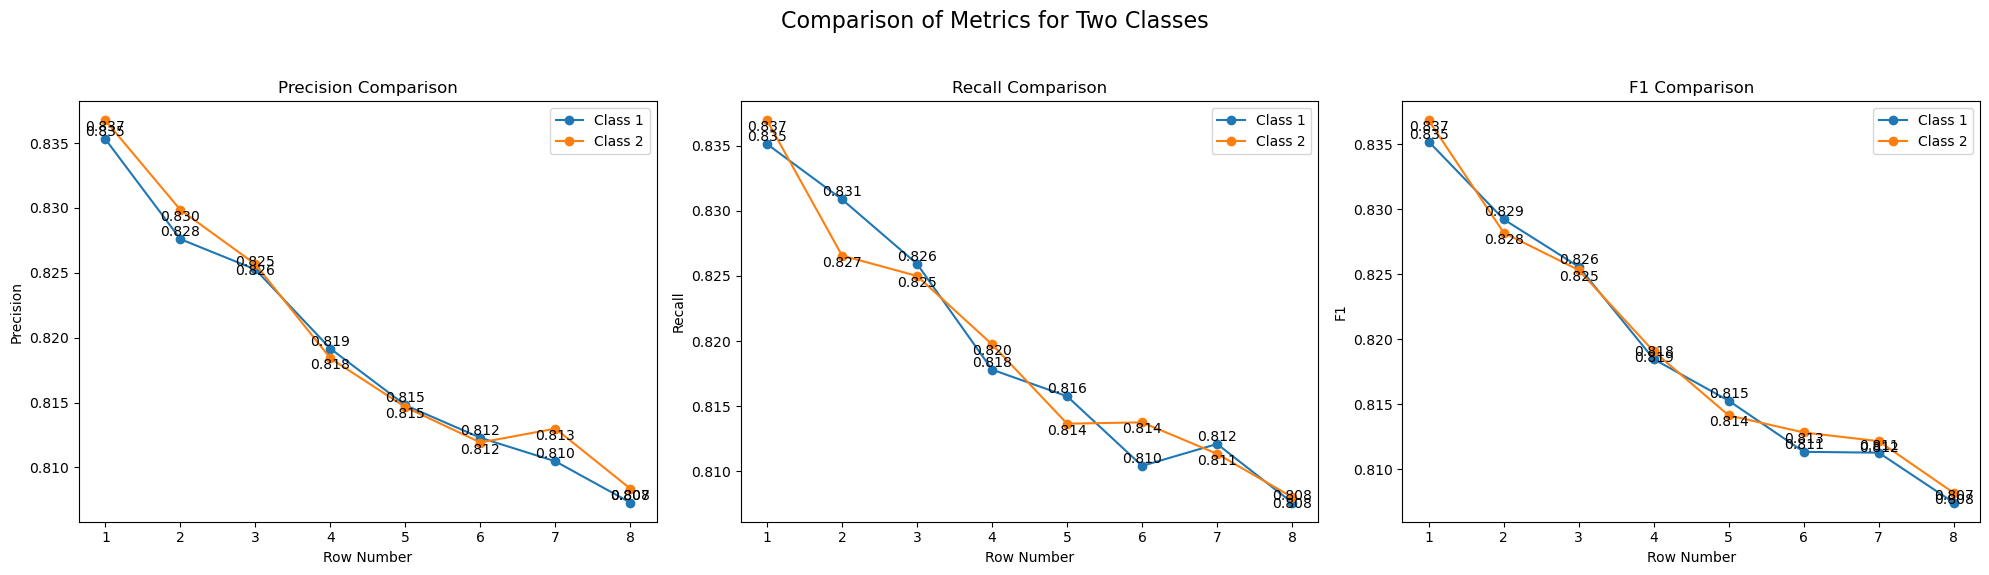

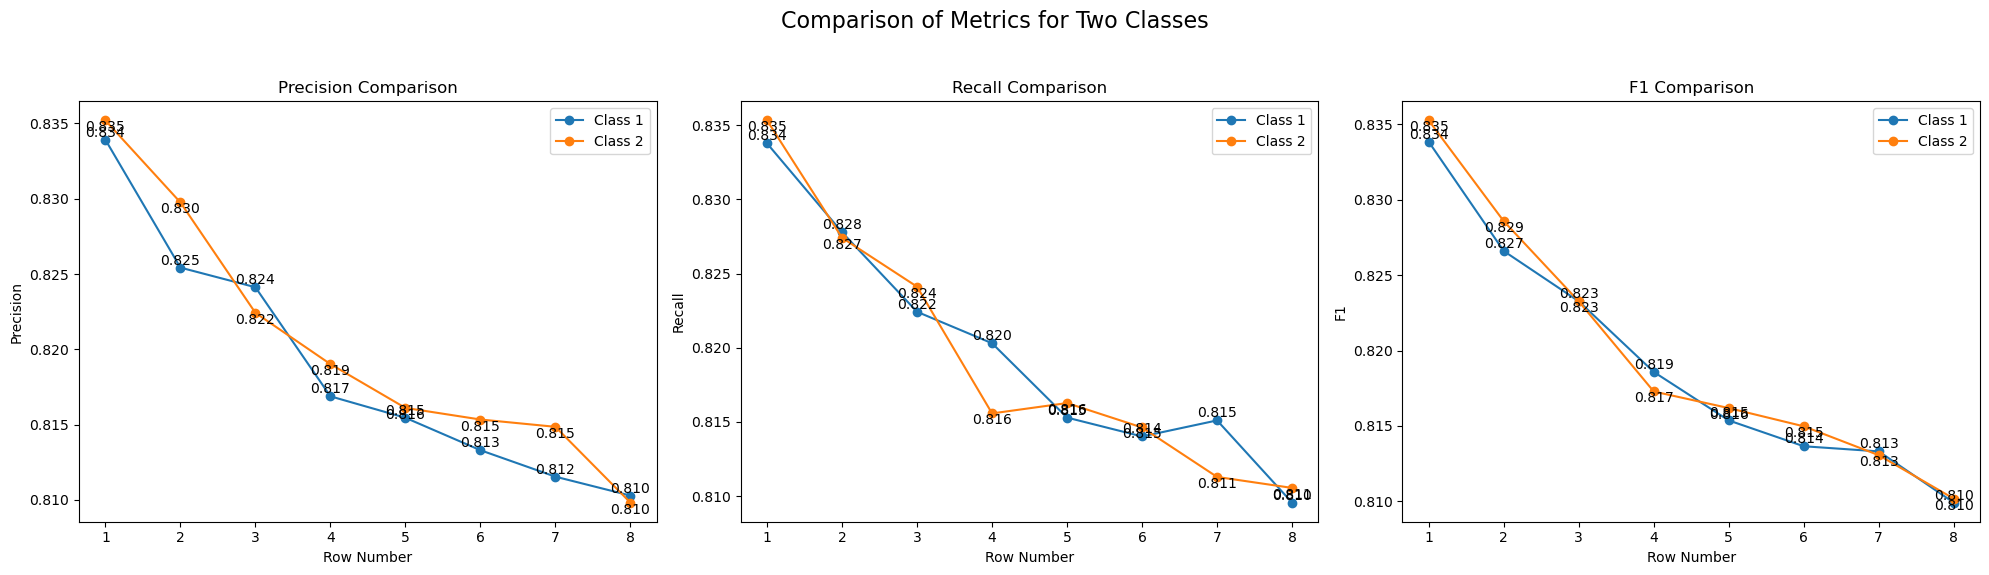

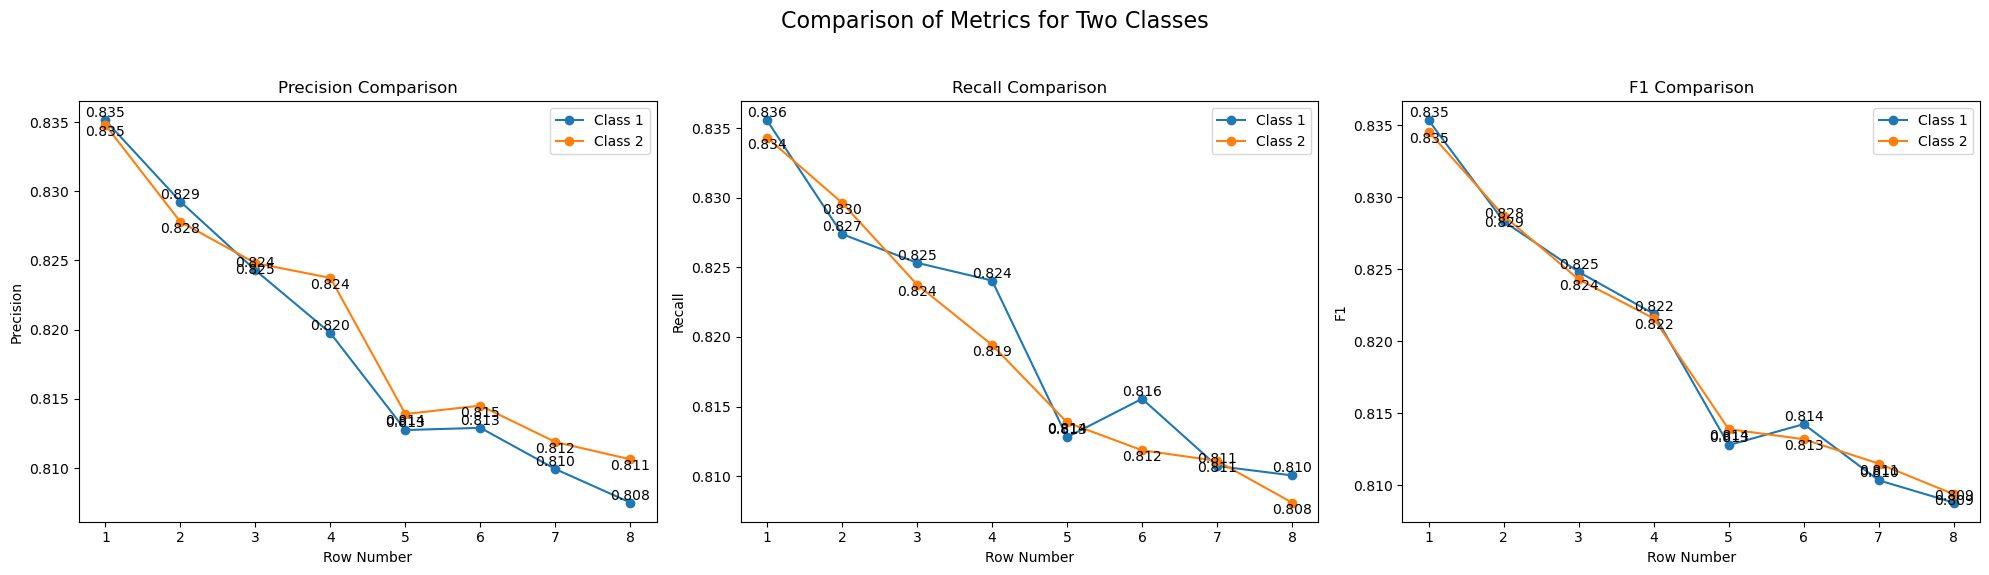

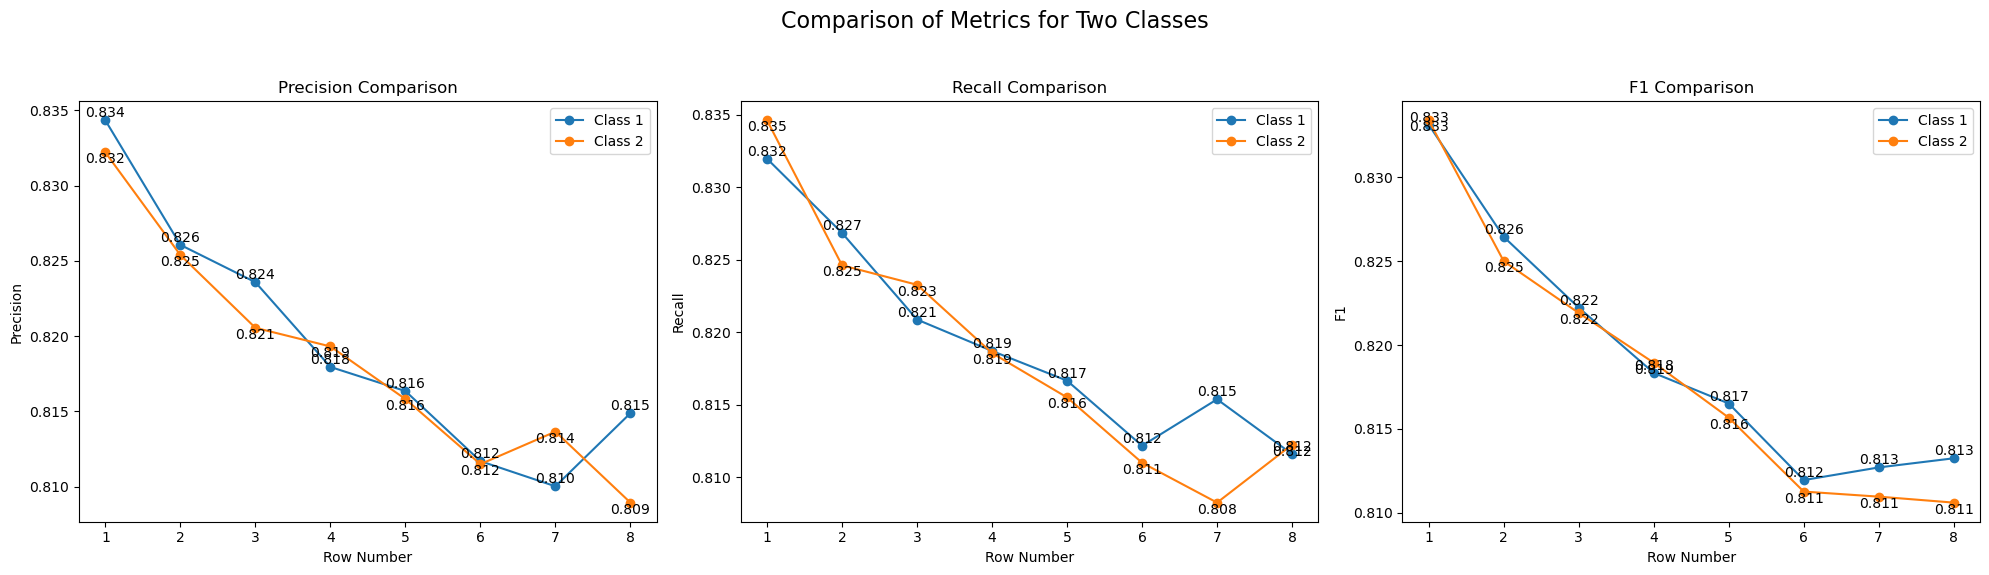

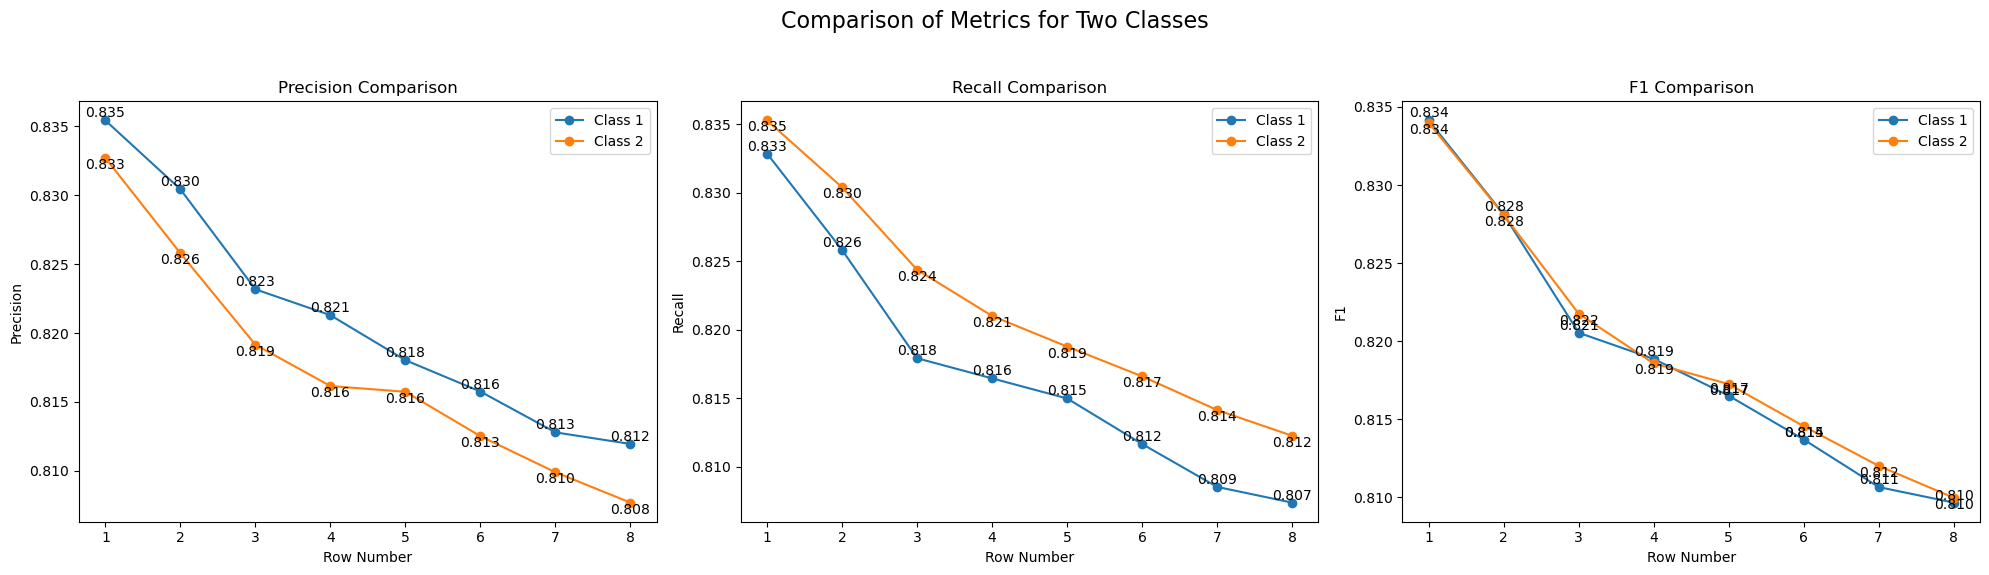

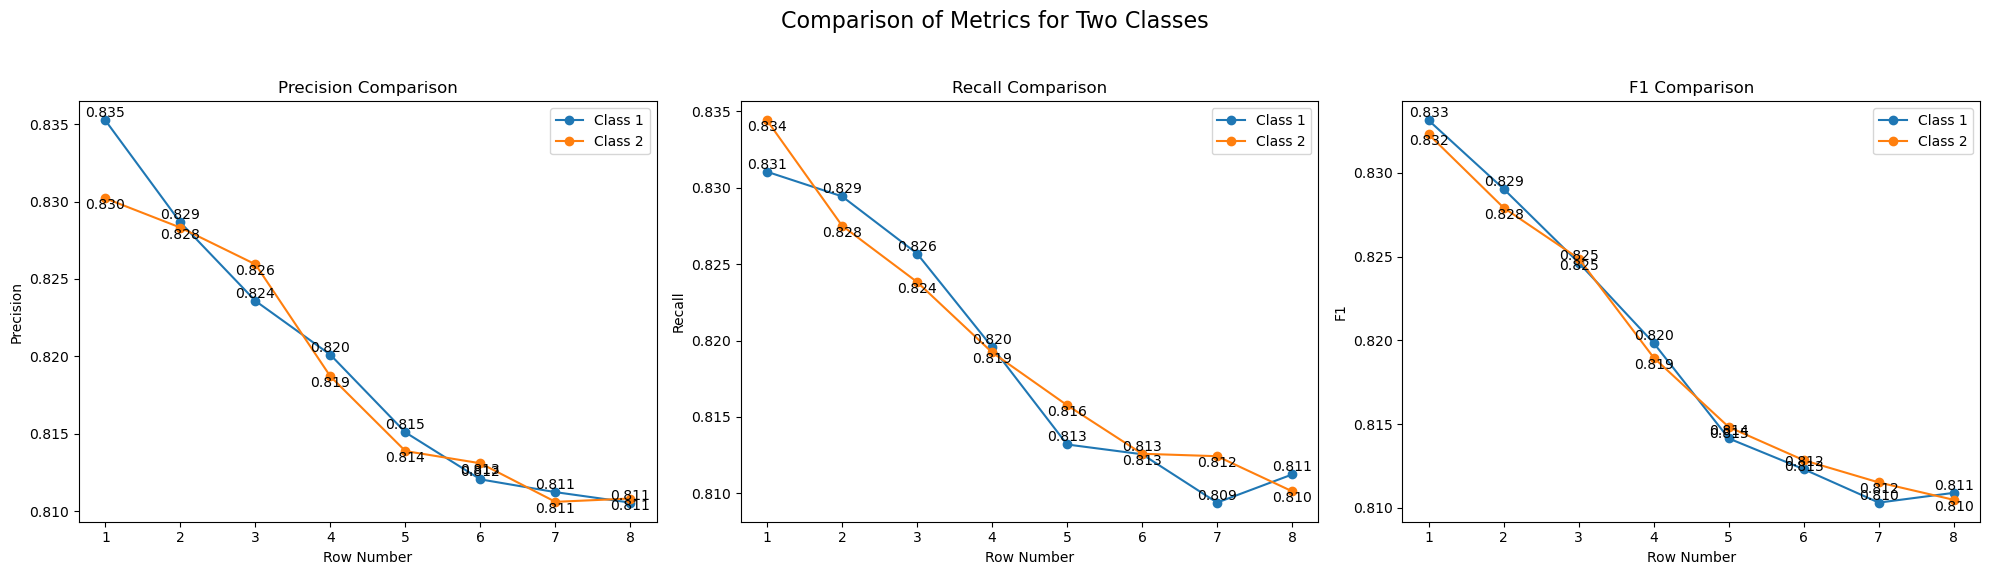

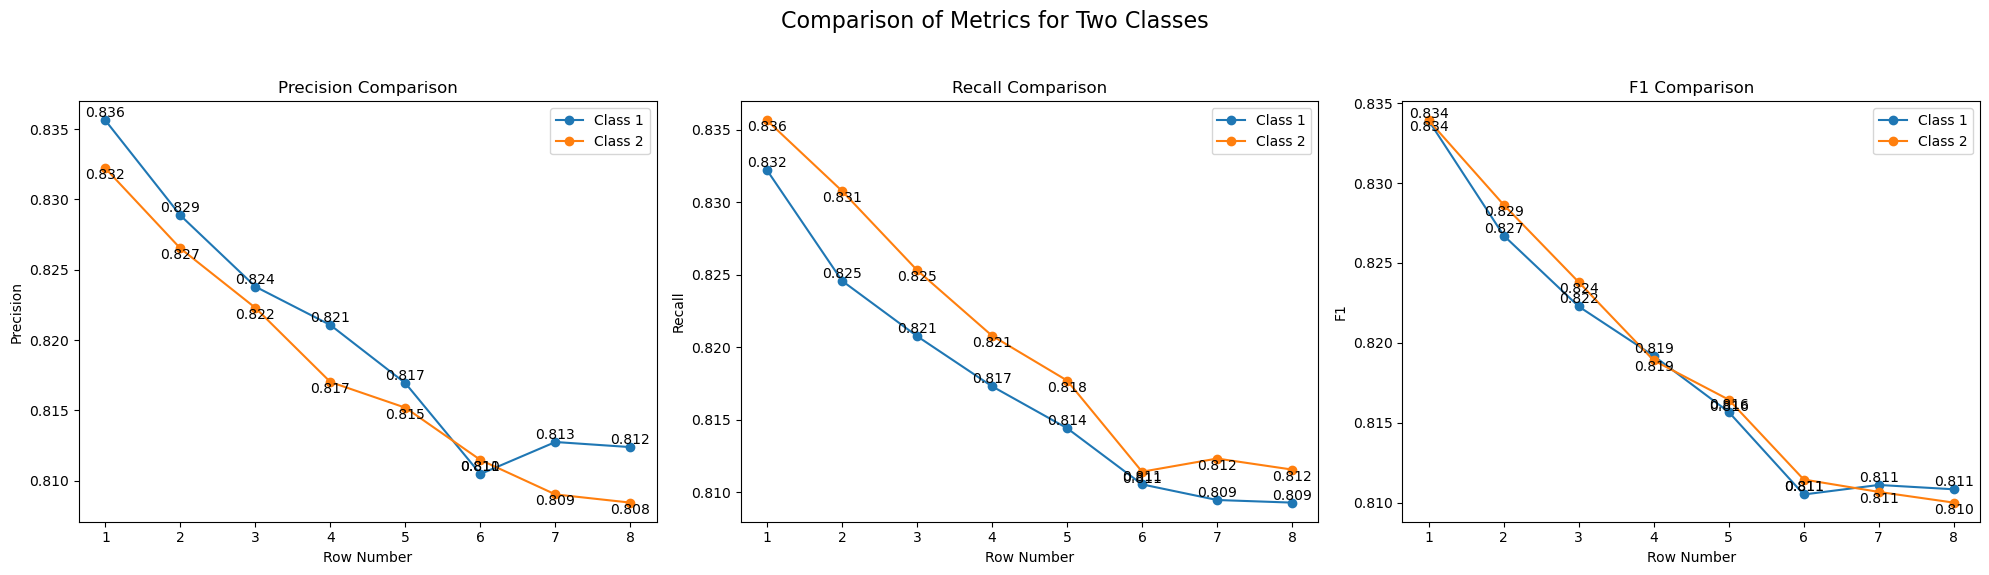

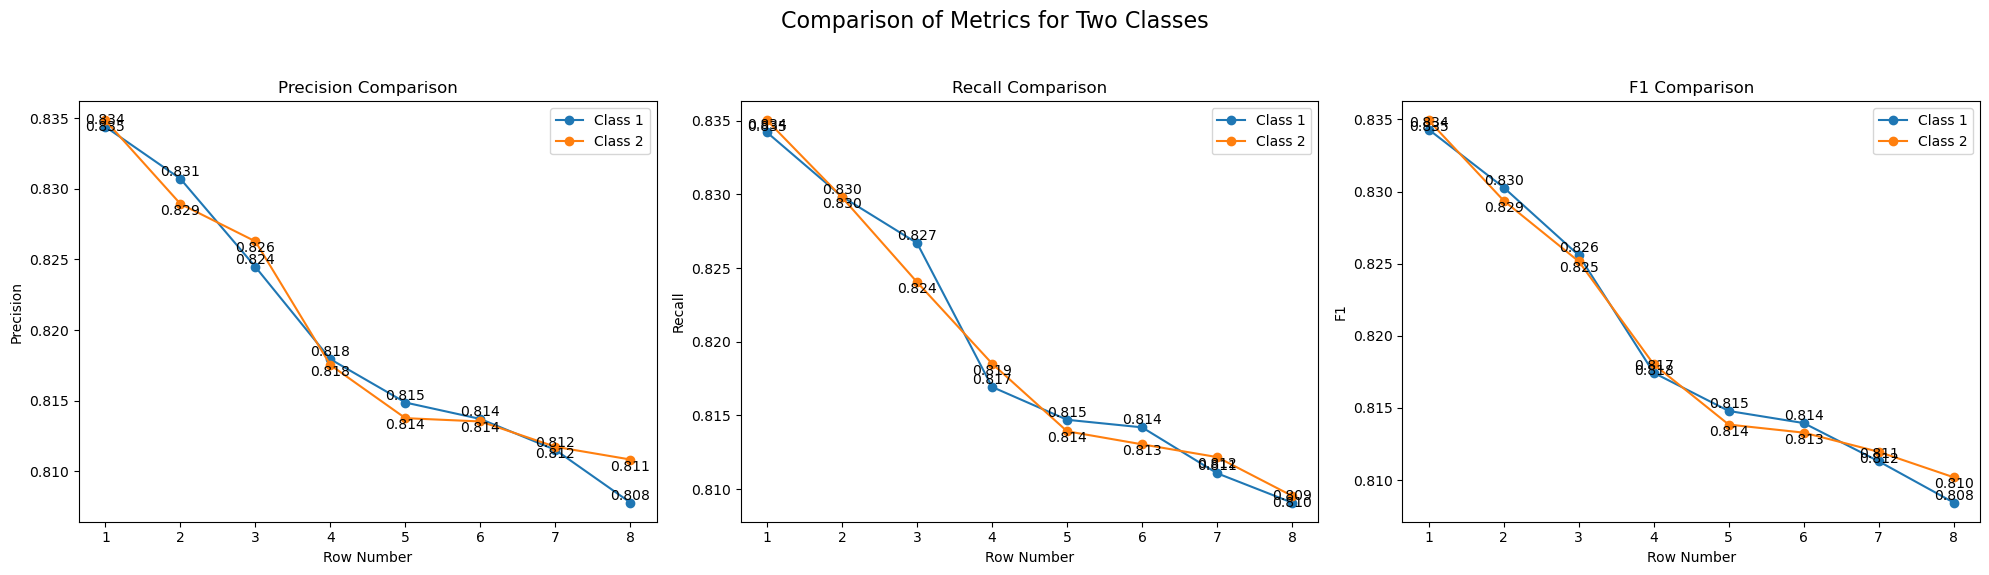

In [131]:
def plot_metric_comparison(df, y_min=0.785, y_max=0.839):
    metrics = ['precision', 'recall', 'f1']
    n_rows = len(df)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Comparison of Metrics for Two Classes', fontsize=16)
    
    for idx, metric in enumerate(metrics):
        ax = axs[idx]
        
        class1_values = [val[0] for val in df[metric]]
        class2_values = [val[1] for val in df[metric]]
        
        x = range(1, n_rows + 1)
        
        ax.plot(x, class1_values, 'o-', label='Class 1')
        ax.plot(x, class2_values, 'o-', label='Class 2')
        
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel('Row Number')
        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_xticks(x)
        ax.legend()
        #ax.set_ylim(y_min, y_max)
        # Add value labels for each point
        for i, (v1, v2) in enumerate(zip(class1_values, class2_values)):
            ax.text(i+1, v1, f'{v1:.3f}', ha='center', va='bottom')
            ax.text(i+1, v2, f'{v2:.3f}', ha='center', va='top')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()
# Usage:
#plot_metric_comparison_lines(df)


#dff = subsets['subset_1']
# Usage:
for f in subsets.keys():
   plot_metric_comparison(subsets[f])
    

In [90]:
subsets

{'subset_2': Empty DataFrame
 Columns: [accuracy, precision, recall, f1, support, class_distribution]
 Index: []}

In [ ]:
dff = subsets['subset_2']
#for dff in subsets.values():
def metricplot(dff, metric
               ):    
    x = [val[0] for val in dff[metric]]
    y = [val[1] for val in dff[metric]]
    avgf1 = np.mean((x,y), axis=0)
    
    plt.scatter(x,y)
    plt.ylim(np.min(x)*0.5,np.max(x)*1.2)
    #plt.xlim(np.min(x)*0.8,np.max(x)*1.2)
    #plt.scatter(dff['accuracy'].values, avgf1)
    plt.xlabel(f'Class 1')
    plt.ylabel(f'Class 2')
    plt.title(f'{metric}')
    #plt.show()

plt.figure(figsize=(5,4))
for dff in subsets.values():
    #metricplot(dff, 'f1') 
    metricplot(dff, 'class_distribution') 
    #plt.ylim(top=1)

plt.figure(figsize=(5,4))

for dff in subsets.values():
    #metricplot(dff, 'f1') 
    metricplot(dff, 'f1') 
    #plt.ylim(top=1)

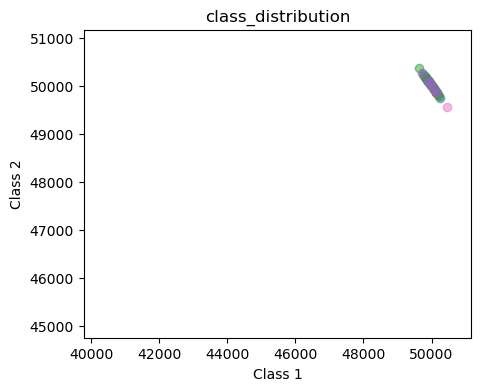

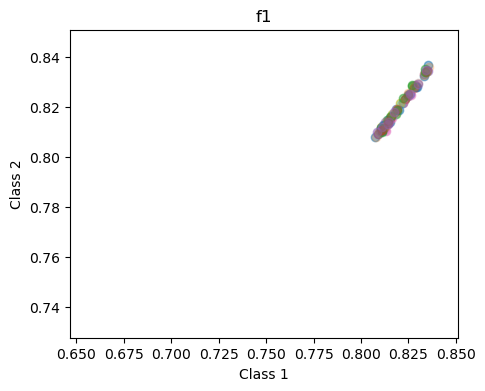

In [111]:
dff = subsets['subset_2']
#for dff in subsets.values():
def metricplot(dff, metric
               ):    
    x = [val[0] for val in dff[metric]]
    y = [val[1] for val in dff[metric]]
    avgf1 = np.mean((x,y), axis=0)
    
    plt.scatter(x,y, alpha=0.5)
    plt.ylim(np.min(x)*0.9,np.max(x)*1.02)
    plt.xlim(np.min(x)*0.8,np.max(x)*1.02)
    plt.scatter(dff['accuracy'].values, avgf1, alpha=0.2)
    plt.xlabel(f'Class 1')
    plt.ylabel(f'Class 2')
    plt.title(f'{metric}')
    #plt.show()

plt.figure(figsize=(5,4))
for dff in subsets.values():
    #metricplot(dff, 'f1') 
    metricplot(dff, 'class_distribution') 
    #plt.ylim(top=1)

plt.figure(figsize=(5,4))

for dff in subsets.values():
    #metricplot(dff, 'f1') 
    metricplot(dff, 'f1') 
    #plt.ylim(top=1)

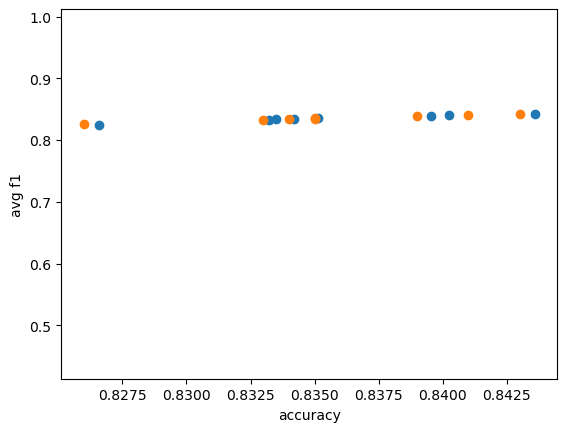

In [16]:
dff = subsets['subset_2']
for dff in subsets.values():
    
    x = [val[0] for val in dff['f1']]
    y = [val[1] for val in dff['f1']]
    plt.scatter(x,y)
    plt.ylim(np.min(x)*0.5,np.max(x)*1.2)
    avgf1 = np.mean((x,y), axis=0)
    #plt.scatter(x,y)
    plt.xlabel('accuracy')
    plt.ylabel('avg f1')
    plt.scatter(dff['accuracy'].values, avgf1)
    #plt.show()
    

In [123]:
dff = subsets['subset_2']

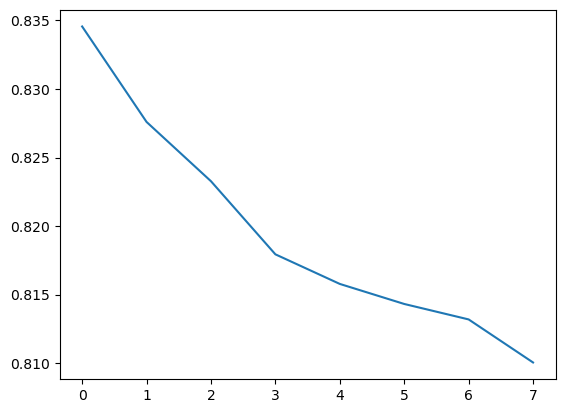

In [129]:
plt.plot(dff['avg_f1'].values)

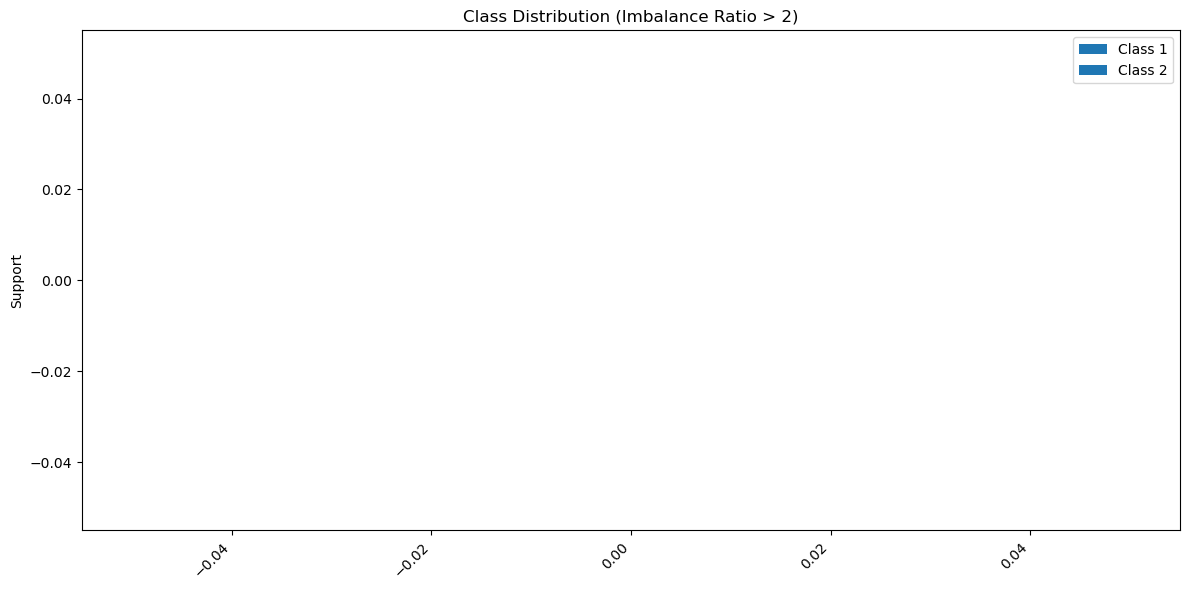

Empty DataFrame
Columns: [support, imbalance_ratio]
Index: []


In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming your DataFrame is named 'df'
# Convert support column to list of integers if it's not already
df['support'] = df['support']
# Calculate imbalance ratio
df['imbalance_ratio'] = df['support'].apply(lambda x: max(x) / min(x) if min(x) > 0 else float('inf'))

# Set threshold for imbalance (adjust as needed)
threshold = 2  # This means one class is at least twice as large as the other

# Filter rows based on threshold
imbalanced_df = df[df['imbalance_ratio'] > threshold]

# Sort by imbalance ratio for better visualization
imbalanced_df = imbalanced_df.sort_values('imbalance_ratio', ascending=False)

# Prepare data for plotting
labels = [f"{row[0]}_{row[1]}_{row[2]}" for row in imbalanced_df.index]
first_values = [val[0] for val in imbalanced_df['support']]
second_values = [val[1] for val in imbalanced_df['support']]

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars
ax.bar(labels, first_values, label='Class 1')
ax.bar(labels, second_values, bottom=first_values, label='Class 2')

# Customize the plot
ax.set_ylabel('Support')
ax.set_title(f'Class Distribution (Imbalance Ratio > {threshold})')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print imbalance ratios
print(imbalanced_df[['support', 'imbalance_ratio']])

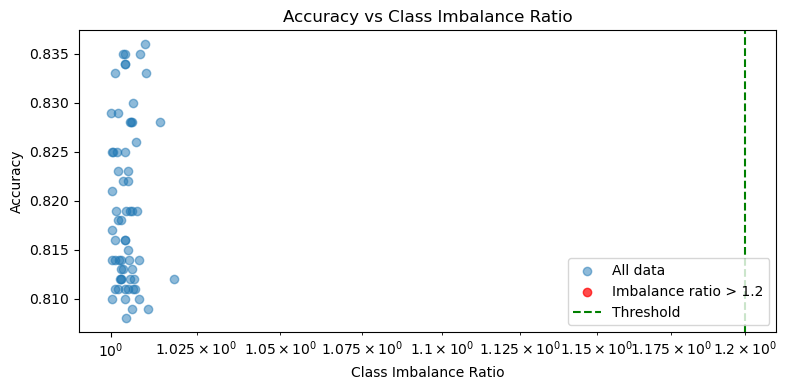

Summary Statistics:
       imbalance_ratio
count        64.000000
mean          1.004583
std           0.003353
min           1.000040
25%           1.002072
50%           1.004169
75%           1.006058
max           1.018286

Highly Imbalanced Classes (above threshold):
Empty DataFrame
Columns: [accuracy, support, imbalance_ratio]
Index: []


In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming your DataFrame is named 'df'
# Calculate imbalance ratio
df['imbalance_ratio'] = df['class_distribution'].apply(lambda x: max(x) / min(x) if min(x) > 0 else float('inf'))

# Set threshold for imbalance (adjust as needed)
threshold = 1.2  # This means one class is at least twice as large as the other

# Create the scatter plot
plt.figure(figsize=(8, 4))

# Plot all points
plt.scatter(df['imbalance_ratio'], df['accuracy'], alpha=0.5, label='All data')

# Highlight points above threshold
above_threshold = df[df['imbalance_ratio'] > threshold]
plt.scatter(above_threshold['imbalance_ratio'], above_threshold['accuracy'], 
            color='red', alpha=0.7, label=f'Imbalance ratio > {threshold}')

# Add labels and title
plt.xlabel('Class Imbalance Ratio')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Class Imbalance Ratio')

# Add a vertical line at the threshold
plt.axvline(x=threshold, color='green', linestyle='--', label='Threshold')

# Log scale for x-axis if ratios vary widely
plt.xscale('log')

# Add legend
plt.legend(loc=4)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(df[['accuracy', 'imbalance_ratio']].describe())

# Print details for highly imbalanced classes
print("\nHighly Imbalanced Classes (above threshold):")
print(above_threshold[['accuracy', 'support', 'imbalance_ratio']])

In [116]:
df

accuracy                                 precision  \
1 NLF_1 1    0.836  [0.8353033409721384, 0.8367493134874836]   
        2    0.829   [0.827598559175307, 0.8298526662780648]   
        3    0.825  [0.8252592045068622, 0.8256612538293655]   
        4    0.819  [0.8191551215991338, 0.8184067194701036]   
        5    0.815  [0.8147941492965605, 0.8146453089244852]   
...            ...                                       ...   
8 NLF_1 4    0.818  [0.8179358175148831, 0.8175250942906747]   
        5    0.814  [0.8148717130202306, 0.8137655880348049]   
        6    0.814  [0.8137074884240779, 0.8135321468654801]   
        7    0.812  [0.8115192689232249, 0.8117402846250574]   
        8    0.809  [0.8077896004818309, 0.8108388125124527]   

                                             recall  \
1 NLF_1 1  [0.8351186767690978, 0.8369325080110662]   
        2  [0.8308725100397595, 0.8265630943562434]   
        3   [0.825919187476258, 0.8250005001700578]   
        4  [0.8178106046958507, 0.8197478067984253]   
        5  [0.8157695223654283, 0.8136653434379887]   
...                                             ...   
8 NLF_1 4  [0.8169369369369369, 0.8185214785214785]   
        5  [0.8147091677970159, 0.8139287719579691]   
        6  [0.8141949914127092, 0.8130433040900533]   
        7     [0.811080398990506, 0.81217797659464]   
        8   [0.809089081037603, 0.8095484384324647]   

                                                 f1         support  \
1 NLF_1 1  [0.8352109986633569, 0.8368409007234047]  [49757, 50243]   
        2  [0.8292323030907278, 0.8282046138415246]  [50051, 49949]   
        3  [0.8255890640925715, 0.8253307447511158]  [50017, 49983]   
        4  [0.8184823109900237, 0.8190767141887305]  [49959, 50041]   
        5   [0.815281544105918, 0.8141550312951372]  [50122, 49878]   
...                                             ...             ...   
8 NLF_1 4  [0.8174360720760424, 0.8180229829973742]  [49950, 50050]   
        5   [0.814790432301953, 0.8138471718164136]  [50132, 49868]   
        6  [0.8139511669228773, 0.8132876520205966]  [50074, 49926]   
        7  [0.8112997746055597, 0.8119590716246569]  [49926, 50074]   
        8  [0.8084388185654009, 0.8101931116862433]  [49730, 50270]   

          class_distribution  imbalance_ratio  
1 NLF_1 1     [49757, 50243]         1.009767  
        2     [50051, 49949]         1.002042  
        3     [50017, 49983]         1.000680  
        4     [49959, 50041]         1.001641  
        5     [50122, 49878]         1.004892  
...                      ...              ...  
8 NLF_1 4     [49950, 50050]         1.002002  
        5     [50132, 49868]         1.005294  
        6     [50074, 49926]         1.002964  
        7     [49926, 50074]         1.002964  
        8     [49730, 50270]         1.010859  

[64 rows x 7 columns]

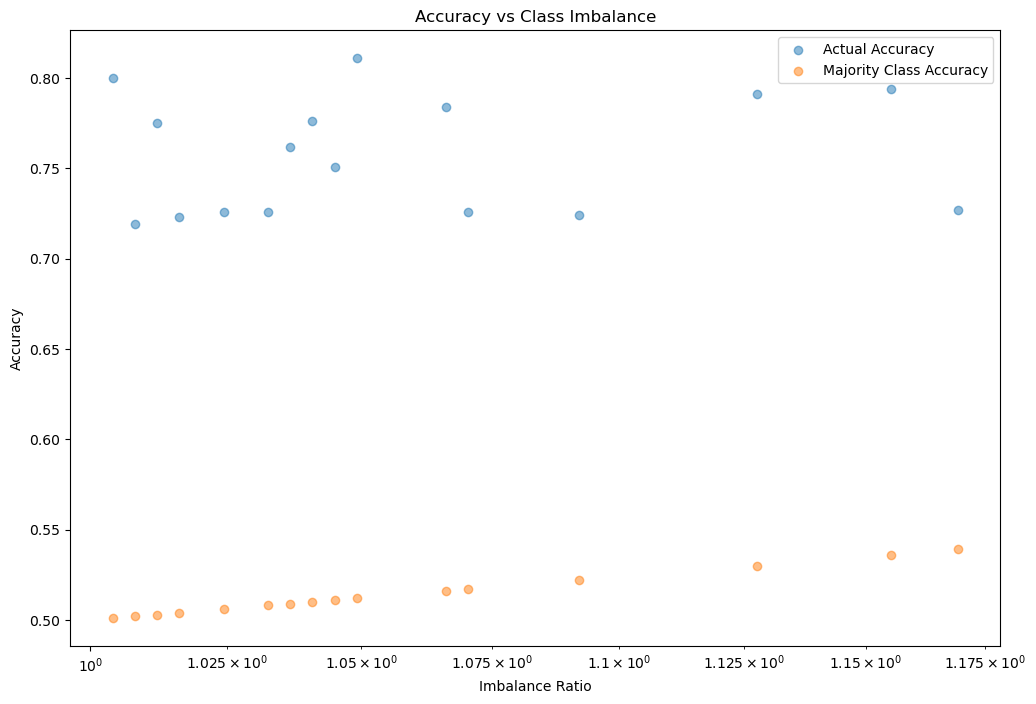

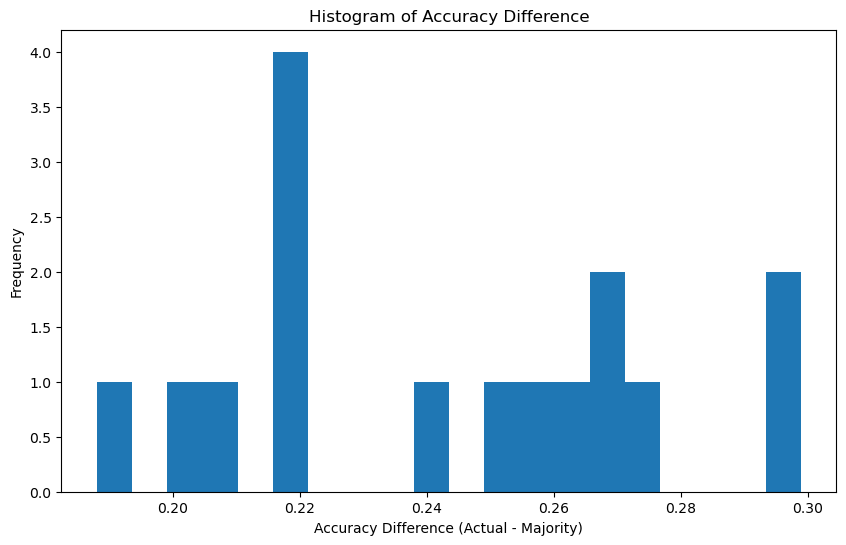

Summary Statistics:
       majority_accuracy  precision_diff
count          16.000000       16.000000
mean            0.514125        0.029204
std             0.011916        0.022261
min             0.501000        0.001756
25%             0.505500        0.013335
50%             0.510500        0.023626
75%             0.518250        0.036630
max             0.539000        0.076709

Proportion of cases where accuracy equals majority class accuracy: 0.00

Cases with large accuracy discrepancies:
      accuracy  majority_accuracy     support  \
1 2 1    0.811              0.512  [488, 512]   
    2    0.784              0.516  [484, 516]   
    3      0.8              0.501  [501, 499]   
    4    0.791              0.530  [530, 470]   
    5    0.794              0.536  [536, 464]   
    6    0.776              0.510  [490, 510]   
    7    0.762              0.509  [491, 509]   
    8    0.775              0.503  [497, 503]   
  3 1    0.726              0.517  [517, 483]   
    2 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Assuming your DataFrame is named 'df' and has columns 'accuracy', 'support', and 'precision'
# If not, please adjust the column names accordingly

def analyze_classifier_bias(df):
   
    # Calculate class imbalance ratio
    df['imbalance_ratio'] = df['support'].apply(lambda x: max(x) / min(x) if min(x) > 0 else float('inf'))
    
    # Determine majority class (0 for first class, 1 for second class)
    df['majority_class'] = df['support'].apply(lambda x: 0 if x[0] > x[1] else 1)
    
    # Calculate accuracy if always predicting majority class
    df['majority_accuracy'] = df['support'].apply(lambda x: max(x) / sum(x))
    
    # Compare actual accuracy with majority class accuracy
    df['accuracy_diff'] = df['accuracy'] - df['majority_accuracy']
    
    # Analyze precision (assuming 'precision' column exists and contains [prec_class_0, prec_class_1])
    df['precision'] = df['precision']
    df['precision_diff'] = df['precision'].apply(lambda x: abs(x[0] - x[1]))
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Scatter plot of accuracy vs imbalance ratio
    plt.scatter(df['imbalance_ratio'], df['accuracy'], alpha=0.5, label='Actual Accuracy')
    plt.scatter(df['imbalance_ratio'], df['majority_accuracy'], alpha=0.5, label='Majority Class Accuracy')
    
    plt.xlabel('Imbalance Ratio')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Class Imbalance')
    plt.legend()
    plt.xscale('log')
    plt.show()
    
    # Histogram of accuracy difference
    plt.figure(figsize=(10, 6))
    plt.hist(df['accuracy_diff'], bins=20)
    plt.xlabel('Accuracy Difference (Actual - Majority)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Accuracy Difference')
    plt.show()
    
    # Print summary statistics
    print("Summary Statistics:")
    print(df[['accuracy', 'majority_accuracy', 'accuracy_diff', 'precision_diff']].describe())
    
    # Check for consistent bias
    consistent_bias = (df['accuracy'] == df['majority_accuracy']).mean()
    print(f"\nProportion of cases where accuracy equals majority class accuracy: {consistent_bias:.2f}")
    
    # Analyze cases with large discrepancies
    large_diff = df[abs(df['accuracy_diff']) > 0.1]
    print("\nCases with large accuracy discrepancies:")
    print(large_diff[['accuracy', 'majority_accuracy', 'support', 'precision']])
    
    # Overall bias check
    avg_precision_diff = df['precision_diff'].mean()
    print(f"\nAverage precision difference between classes: {avg_precision_diff:.2f}")
    
    return df

# Run the analysis
df_analyzed = analyze_classifier_bias(df)